In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f1e80da8a1a77fd702df68bb3170529dc31dc7baeaecbb6df24cdfd45cdfe86f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
pip install recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.0/356.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 17.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.9/251.9 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.8/919.8 kB 63.0 MB/s eta 0:00:00
     ━━━━━━

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType

from recommenders.datasets import movielens
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.spark_splitters import spark_random_split

print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"PySpark version: {pyspark.__version__}")

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Pandas version: 2.0.3
PySpark version: 3.5.1


In [ ]:
MOVIELENS_DATA_SIZE = "100k"

COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_RATING = "Rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "Timestamp"

In [ ]:
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),
    )
)

In [ ]:
RANK = 10
MAX_ITER = 15
REG_PARAM = 0.05

In [ ]:
K = 10

In [ ]:
spark = start_or_get_spark("ALS Deep Dive", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

In [ ]:
dfs = movielens.load_spark_df(spark=spark, size=MOVIELENS_DATA_SIZE, schema=schema)

100%|██████████| 4.81k/4.81k [00:00<00:00, 14.4kKB/s]


In [ ]:
dfs_train, dfs_test = spark_random_split(dfs, ratio=0.75, seed=42)

In [ ]:
als = ALS(
    maxIter=MAX_ITER,
    rank=RANK,
    regParam=REG_PARAM,
    userCol=COL_USER,
    itemCol=COL_ITEM,
    ratingCol=COL_RATING,
    coldStartStrategy="drop"
)

model = als.fit(dfs_train)

In [ ]:
dfs_pred = model.transform(dfs_test).drop(COL_RATING)
dfs_pred.show()

+------+-------+---------+----------+
|UserId|MovieId|Timestamp|prediction|
+------+-------+---------+----------+
|   148|      8|877020297| 3.5447783|
|   148|     56|877398212| 2.9786205|
|   148|     71|877019251| 3.8646007|
|   148|     78|877399018| 2.1544406|
|   148|    133|877019251| 2.2809348|
|   148|    169|877020297| 4.3139653|
|   148|    172|877016513| 4.9057045|
|   148|    194|877015066|  4.385404|
|   148|    222|877398901| 3.9540138|
|   148|    228|877016514| 4.7031655|
|   148|    357|877016735| 3.0201824|
|   148|    432|877019698| 4.3904095|
|   148|    474|877019882| 3.9106882|
|   148|    529|877398901| 4.5425577|
|   148|    588|877399018| 2.7352962|
|   148|    713|877021535| 4.2782464|
|   463|      7|877385180| 2.6784225|
|   463|     10|890453075| 3.0508723|
|   463|     20|877385590| 4.1145506|
|   463|     24|877385731|  2.507069|
+------+-------+---------+----------+
only showing top 20 rows



In [ ]:
evaluations = SparkRatingEvaluation(
    dfs_test,
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)

RMSE score = 0.968722941905609
MAE score = 0.7516804984245017
R2 score = 0.2584448544206047
Explained variance score = 0.2633202631789433


In [ ]:
# Get the cross join of all user-item pairs and score them.
users = dfs_train.select(COL_USER).distinct()
items = dfs_train.select(COL_ITEM).distinct()
user_item = users.crossJoin(items)
dfs_pred = model.transform(user_item)

# Remove seen items.
dfs_pred_exclude_train = dfs_pred.alias("pred").join(
    dfs_train.alias("train"),
    (dfs_pred[COL_USER] == dfs_train[COL_USER]) & (dfs_pred[COL_ITEM] == dfs_train[COL_ITEM]),
    how='outer'
)

dfs_pred_final = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

dfs_pred_final.show()

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|     1|      3| 3.1354642|
|     1|      7|  4.583827|
|     1|      9|   4.10964|
|     1|     20| 3.5110586|
|     1|     33| 3.4409182|
|     1|     36| 1.2009766|
|     1|     43|  2.502841|
|     1|     46| 3.7599394|
|     1|     48|  4.483214|
|     1|     50|  5.048281|
|     1|     52|  3.880335|
|     1|     63| 2.5073838|
|     1|     65|  3.140083|
|     1|     84| 2.1475644|
|     1|    113|   4.56666|
|     1|    117|  3.431176|
|     1|    118| 2.9378986|
|     1|    119|  4.606138|
|     1|    161|  3.062041|
|     1|    190|  4.058028|
+------+-------+----------+
only showing top 20 rows



In [ ]:
evaluations = SparkRankingEvaluation(
    dfs_test,
    dfs_pred_final,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=K
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)

Precision@k = 0.047507953340402934
Recall@k = 0.01632822137938396
NDCG@k = 0.04260275989923112
Mean average precision = 0.014543328505354483


In [ ]:
param_dict = {
    "rank": [10, 15, 20],
    "regParam": [0.001, 0.1, 1.0]
}

In [ ]:
param_grid = generate_param_grid(param_dict)

<Axes: xlabel='reg. parameter', ylabel='rank'>

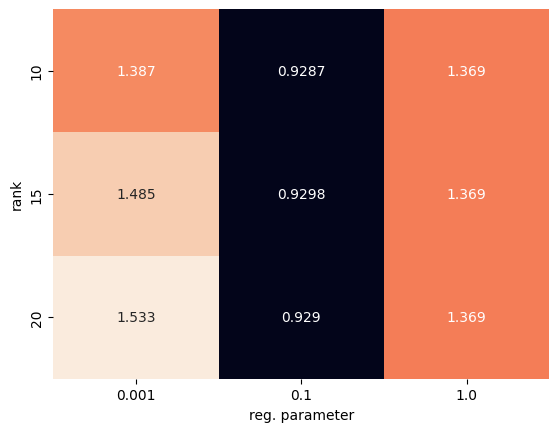

In [ ]:
rmse_score = []

for g in param_grid:
    als = ALS(
        userCol=COL_USER,
        itemCol=COL_ITEM,
        ratingCol=COL_RATING,
        coldStartStrategy="drop",
        **g
    )

    model = als.fit(dfs_train)

    dfs_pred = model.transform(dfs_test).drop(COL_RATING)

    evaluations = SparkRatingEvaluation(
        dfs_test,
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )

    rmse_score.append(evaluations.rmse())

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"])))

rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"),
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))
fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")

In [ ]:
dfs_rec = model.recommendForAllUsers(10)
dfs_rec.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|     1|[{1536, 3.891199}...|
|     3|[{1536, 3.106384}...|
|     5|[{1536, 3.1345372...|
|     6|[{1536, 3.7354307...|
|     9|[{1536, 4.2483497...|
|    12|[{1536, 4.447189}...|
|    13|[{1536, 3.3997421...|
|    15|[{1536, 3.1361632...|
|    16|[{1536, 4.5658073...|
|    17|[{1536, 3.0498176...|
+------+--------------------+
only showing top 10 rows



In [ ]:
users = dfs_train.select(als.getUserCol()).distinct().limit(3)

dfs_rec_subset = model.recommendForUserSubset(users, 10)
dfs_rec_subset.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|   471|[{1536, 3.3287528...|
|   463|[{1536, 3.1125836...|
|   148|[{1536, 3.9075732...|
+------+--------------------+



In [ ]:
spark.stop()